
# 03 - Modular Enhancements

This notebook mirrors the Part 3 experiments but keeps the code lightweight by
relying on helper modules in `src/`.


## Imports & shared setup

In [11]:
from pathlib import Path

import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from IPython.display import Markdown, display
from dataclasses import replace, dataclass

from src.config import load_data_config
from src.dataset_pipeline import prepare_tokenised_splits
from src.embeddings import load_torchtext_glove
from src.reports import build_vocabulary_report
from src.models.birnn import BiLSTMClassifier, BiGRUClassifier
from src.models.cnn import CNNTextClassifier
from src.training import (
    RNNExperimentConfig,
    train_rnn_model,
    build_dataloaders_and_vocab,
    run_model_experiment,
    summarise_run,
)
from src.evaluation import evaluate_model, topic_accuracy_table, classification_report_table
from src.plotting import plot_training_curves

SEED = 7
sns.set_theme(style="whitegrid")

## Data & embeddings

In [12]:
data_config = load_data_config(Path('configs/data.yaml'))
splits = prepare_tokenised_splits(data_config)
len(splits.train), len(splits.validation), len(splits.test)

(4361, 1091, 500)

In [13]:
vocab_report = build_vocabulary_report(
    tokenised_dataset=splits.train,
    min_freq=data_config.vocabulary_min_freq,
    specials=data_config.vocabulary_specials,
)
embedding_result = load_torchtext_glove(
    vocabulary=vocab_report.vocabulary,
    name='6B',
    dim=100,
    trainable=True,
    random_seed=SEED,
)
embedding_tensor = torch.tensor(embedding_result.matrix, dtype=torch.float32)

## Shared experiment configuration

In [14]:
base_config = RNNExperimentConfig(
    epochs=15,
    batch_size=64,
    hidden_dim=128,
    num_layers=1,
    dropout=0.3,
    learning_rate=1e-3,
    weight_decay=1e-4,
    grad_clip=1.0,
    pooling='last_hidden',
    optimizer='adam',
    early_stopping_patience=3,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loaders, label_to_index = build_dataloaders_and_vocab(base_config, splits, vocab_report.vocabulary)
records = {'rows': [], 'histories': {}, 'evaluations': {}, 'label_maps': {}}

## Baseline RNN

Baseline test accuracy: 0.598

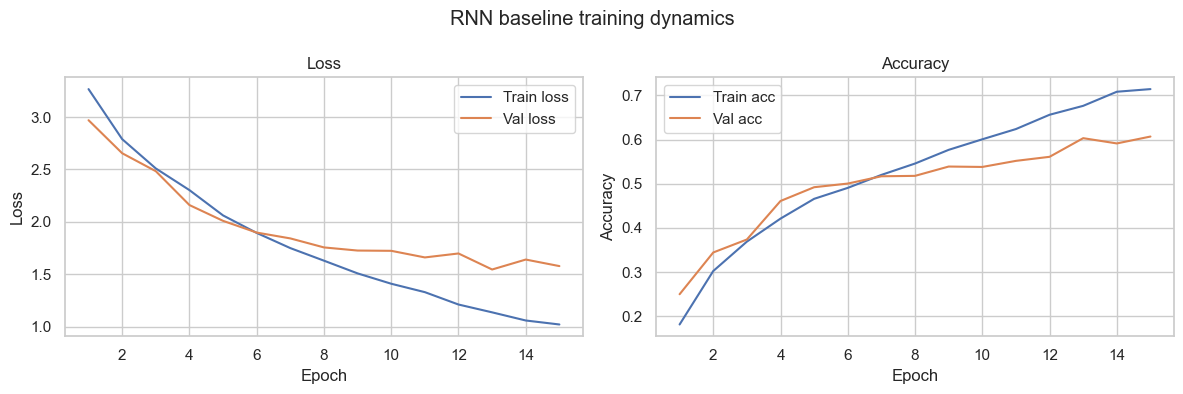

In [15]:
b_hist, b_model, b_label_map, b_loaders = train_rnn_model(
    base_config,
    splits=splits,
    vocabulary=vocab_report.vocabulary,
    embedding_result=embedding_result,
    device=device,
)
b_eval = evaluate_model(b_model, b_loaders.test, device=device)
records['histories']['rnn_baseline'] = b_hist
records['evaluations']['rnn_baseline'] = b_eval
records['label_maps']['rnn_baseline'] = b_label_map
records['rows'].append(summarise_run('rnn_baseline', b_hist, b_eval.accuracy))
plot_training_curves(
    b_hist,
    title='RNN baseline training dynamics',
    output_path=Path('plots/part3_rnn_baseline_curves.png'),
)
display(Markdown(f"Baseline test accuracy: {b_eval.accuracy:.3f}"))

## biLSTM

biLSTM test accuracy: 0.784

(<Figure size 1200x400 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epoch', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epoch', ylabel='Accuracy'>],
       dtype=object))

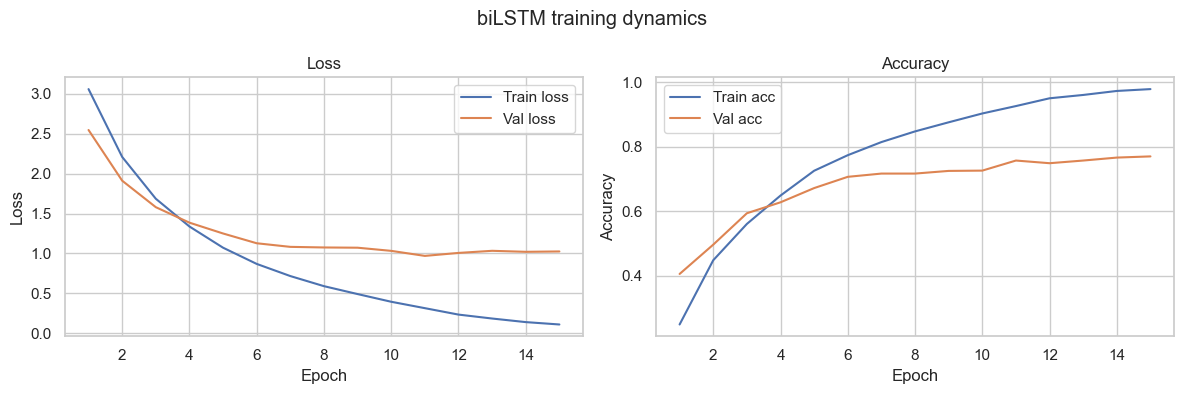

In [16]:
hist_bilstm, model_bilstm, eval_bilstm = run_model_experiment(
    'bilstm',
    model_builder=lambda: BiLSTMClassifier(
        embedding_matrix=embedding_tensor.clone(),
        num_classes=len(label_to_index),
        hidden_dim=base_config.hidden_dim,
        num_layers=base_config.num_layers,
        dropout=base_config.dropout,
    ),
    config=base_config,
    loaders=loaders,
    device=device,
)
records['histories']['bilstm'] = hist_bilstm
records['evaluations']['bilstm'] = eval_bilstm
records['label_maps']['bilstm'] = {idx: label for label, idx in label_to_index.items()}
records['rows'].append(summarise_run('bilstm', hist_bilstm, eval_bilstm.accuracy))
display(Markdown(f"biLSTM test accuracy: {eval_bilstm.accuracy:.3f}"))
plot_training_curves(
    hist_bilstm,
    title='biLSTM training dynamics',
    output_path=Path('plots/part3_bilstm_curves.png'),
)

/var/folders/n9/nqt4flt92tgcz4q081zf11740000gn/T/ipykernel_54091/3276947513.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = [cm.get_cmap('viridis')(acc) for acc in sorted_bilstm_topics['accuracy'].clip(0, 1)]
/var/folders/n9/nqt4flt92tgcz4q081zf11740000gn/T/ipykernel_54091/3276947513.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  sm = cm.ScalarMappable(cmap=cm.get_cmap('viridis'))


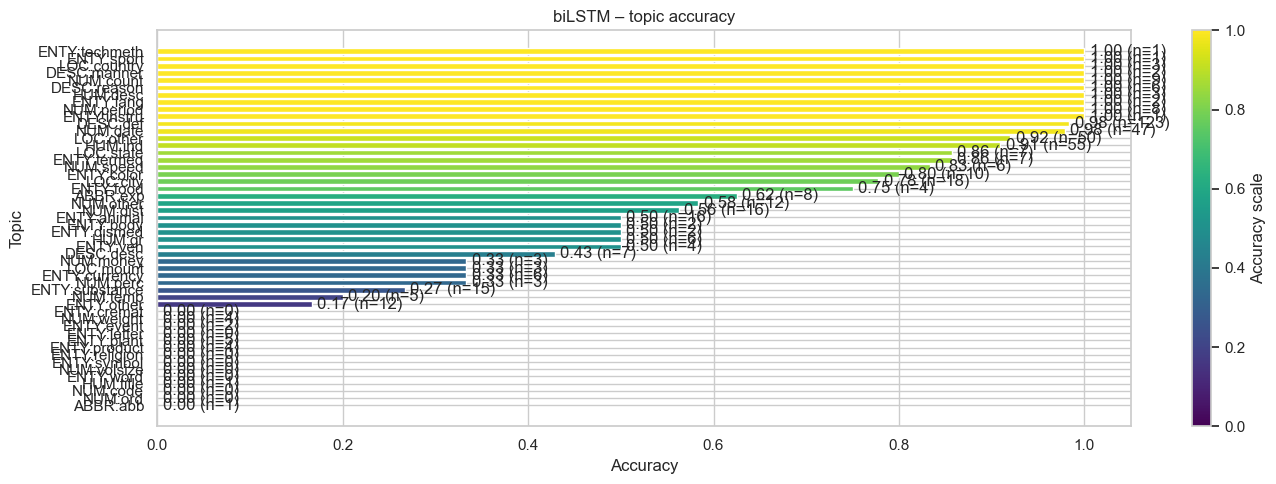

In [ ]:
bilstm_topic_df = topic_accuracy_table(eval_bilstm, records['label_maps']['bilstm'])
sorted_bilstm_topics = bilstm_topic_df.sort_values('accuracy')
fig, ax = plt.subplots(figsize=(14, 14))
colors = [cm.get_cmap('viridis')(acc) for acc in sorted_bilstm_topics['accuracy'].clip(0, 1)]
bars = ax.barh(sorted_bilstm_topics['label'], sorted_bilstm_topics['accuracy'], color=colors)
ax.set_xlabel('Accuracy')
ax.set_ylabel('Topic')
ax.set_title('biLSTM – topic accuracy')
ax.set_xlim(0, 1.05)
ax.bar_label(bars, labels=[f"{acc:.2f} (n={supp})" for acc, supp in zip(sorted_bilstm_topics['accuracy'], sorted_bilstm_topics['support'])], padding=4)
sm = cm.ScalarMappable(cmap=cm.get_cmap('viridis'))
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Accuracy scale')
plt.tight_layout()
fig.savefig('plots/part3_bilstm_topic_accuracy.png', dpi=300)
plt.show()


## biGRU

biGRU test accuracy: 0.808

(<Figure size 1200x400 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epoch', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epoch', ylabel='Accuracy'>],
       dtype=object))

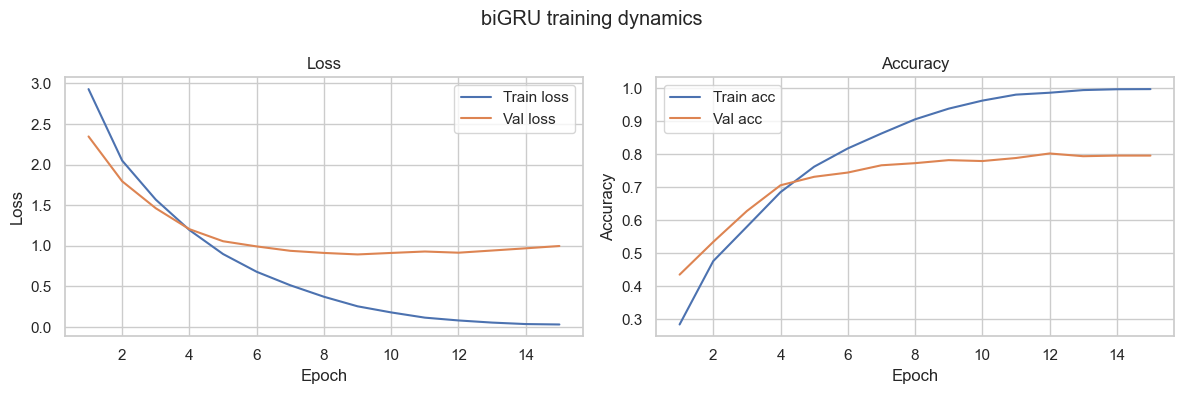

In [19]:
hist_bigru, model_bigru, eval_bigru = run_model_experiment(
    'bigru',
    model_builder=lambda: BiGRUClassifier(
        embedding_matrix=embedding_tensor.clone(),
        num_classes=len(label_to_index),
        hidden_dim=base_config.hidden_dim,
        num_layers=base_config.num_layers,
        dropout=base_config.dropout,
    ),
    config=base_config,
    loaders=loaders,
    device=device,
)
records['histories']['bigru'] = hist_bigru
records['evaluations']['bigru'] = eval_bigru
records['label_maps']['bigru'] = {idx: label for label, idx in label_to_index.items()}
records['rows'].append(summarise_run('bigru', hist_bigru, eval_bigru.accuracy))
display(Markdown(f"biGRU test accuracy: {eval_bigru.accuracy:.3f}"))
plot_training_curves(
    hist_bigru,
    title='biGRU training dynamics',
    output_path=Path('plots/part3_bigru_curves.png'),
)

/var/folders/n9/nqt4flt92tgcz4q081zf11740000gn/T/ipykernel_54091/1461580101.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = [cm.get_cmap('viridis')(acc) for acc in sorted_bigru_topics['accuracy'].clip(0, 1)]
/var/folders/n9/nqt4flt92tgcz4q081zf11740000gn/T/ipykernel_54091/1461580101.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  sm = cm.ScalarMappable(cmap=cm.get_cmap('viridis'))


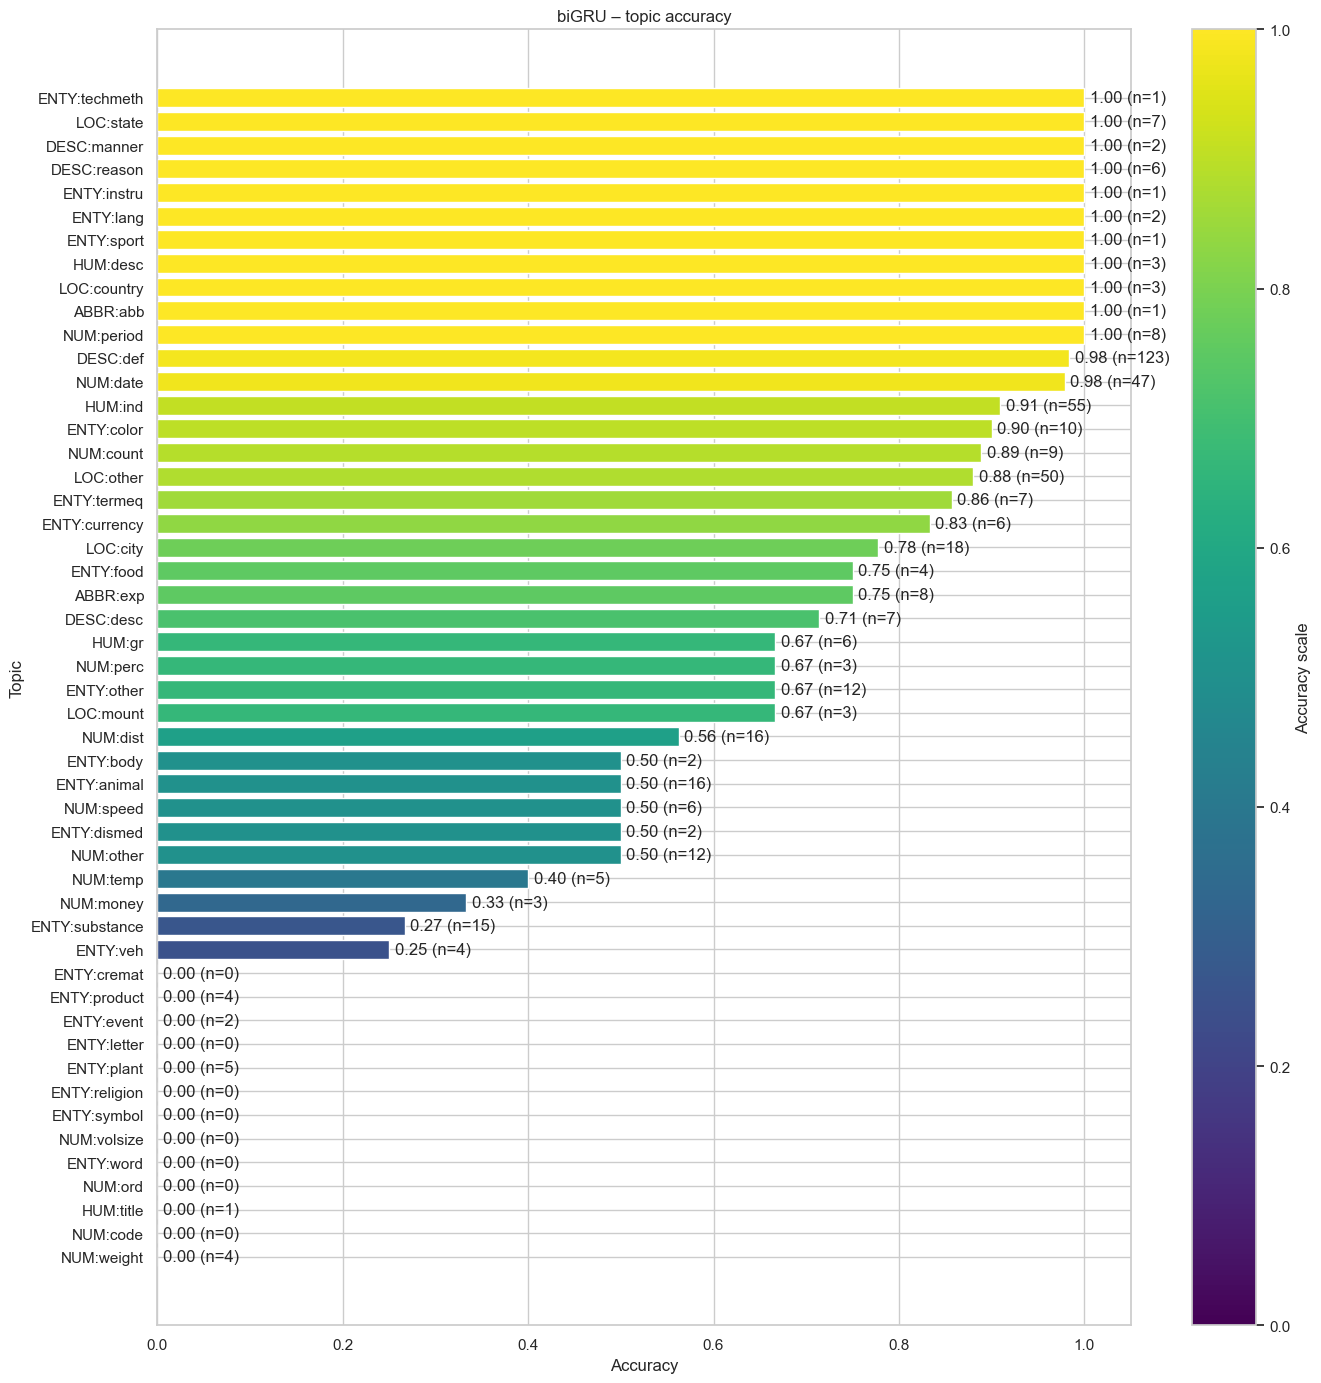

In [20]:
bigru_topic_df = topic_accuracy_table(eval_bigru, records['label_maps']['bigru'])
sorted_bigru_topics = bigru_topic_df.sort_values('accuracy')
fig, ax = plt.subplots(figsize=(14, 14))
colors = [cm.get_cmap('viridis')(acc) for acc in sorted_bigru_topics['accuracy'].clip(0, 1)]
bars = ax.barh(sorted_bigru_topics['label'], sorted_bigru_topics['accuracy'], color=colors)
ax.set_xlabel('Accuracy')
ax.set_ylabel('Topic')
ax.set_title('biGRU – topic accuracy')
ax.set_xlim(0, 1.05)
ax.bar_label(bars, labels=[f"{acc:.2f} (n={supp})" for acc, supp in zip(sorted_bigru_topics['accuracy'], sorted_bigru_topics['support'])], padding=4)
sm = cm.ScalarMappable(cmap=cm.get_cmap('viridis'))
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Accuracy scale')
plt.tight_layout()
fig.savefig('plots/part3_bigru_topic_accuracy.png', dpi=300)
plt.show()


## CNN

CNN test accuracy: 0.836

(<Figure size 1200x400 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epoch', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epoch', ylabel='Accuracy'>],
       dtype=object))

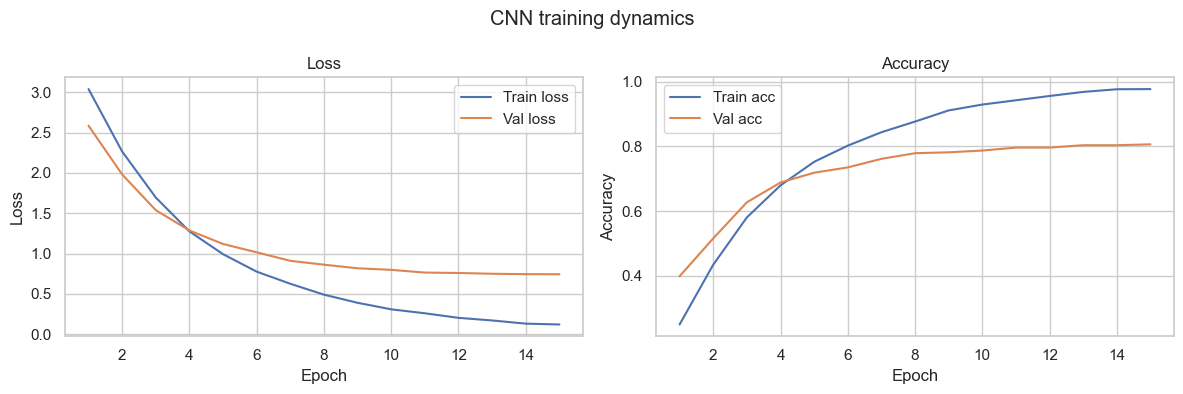

In [21]:
cnn_config = replace(base_config, dropout=0.5, weight_decay=0.0, grad_clip=0.0)
hist_cnn, model_cnn, eval_cnn = run_model_experiment(
    'cnn',
    model_builder=lambda: CNNTextClassifier(
        embedding_matrix=embedding_tensor.clone(),
        num_classes=len(label_to_index),
        dropout=cnn_config.dropout,
    ),
    config=cnn_config,
    loaders=loaders,
    device=device,
)
records['histories']['cnn'] = hist_cnn
records['evaluations']['cnn'] = eval_cnn
records['label_maps']['cnn'] = {idx: label for label, idx in label_to_index.items()}
records['rows'].append(summarise_run('cnn', hist_cnn, eval_cnn.accuracy))
display(Markdown(f"CNN test accuracy: {eval_cnn.accuracy:.3f}"))
plot_training_curves(
    hist_cnn,
    title='CNN training dynamics',
    output_path=Path('plots/part3_cnn_curves.png'),
)

## Summary & comparison

,best_epoch,val_accuracy,test_accuracy
name,,,
cnn,15,0.806599,0.836
bigru,12,0.802016,0.808
bilstm,15,0.769936,0.784
rnn_baseline,15,0.606783,0.598


Best model: **cnn** (test accuracy 0.836)

,label,accuracy,support
49,NUM:weight,0.000000,4
31,HUM:title,0.000000,1
27,ENTY:word,0.000000,0
48,NUM:volsize,0.000000,0
23,ENTY:symbol,0.000000,0
20,ENTY:religion,0.000000,0
19,ENTY:product,0.000000,4
16,ENTY:letter,0.000000,0
42,NUM:ord,0.000000,0
12,ENTY:event,0.000000,2


/var/folders/n9/nqt4flt92tgcz4q081zf11740000gn/T/ipykernel_54091/2439488286.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_vals = [cm.get_cmap('viridis')(acc) for acc in sorted_best_topics['accuracy'].clip(0, 1)]


AttributeError: 'list' object has no attribute 'Normalize'

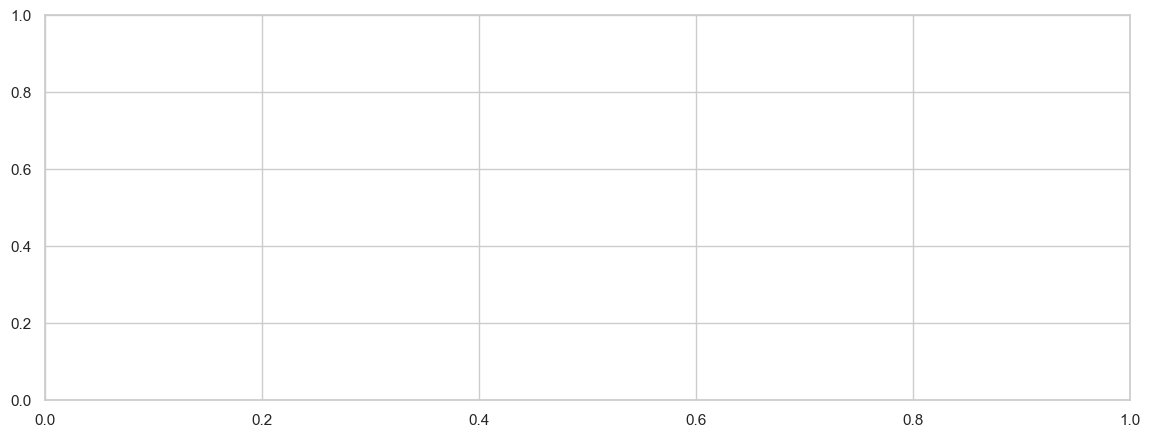

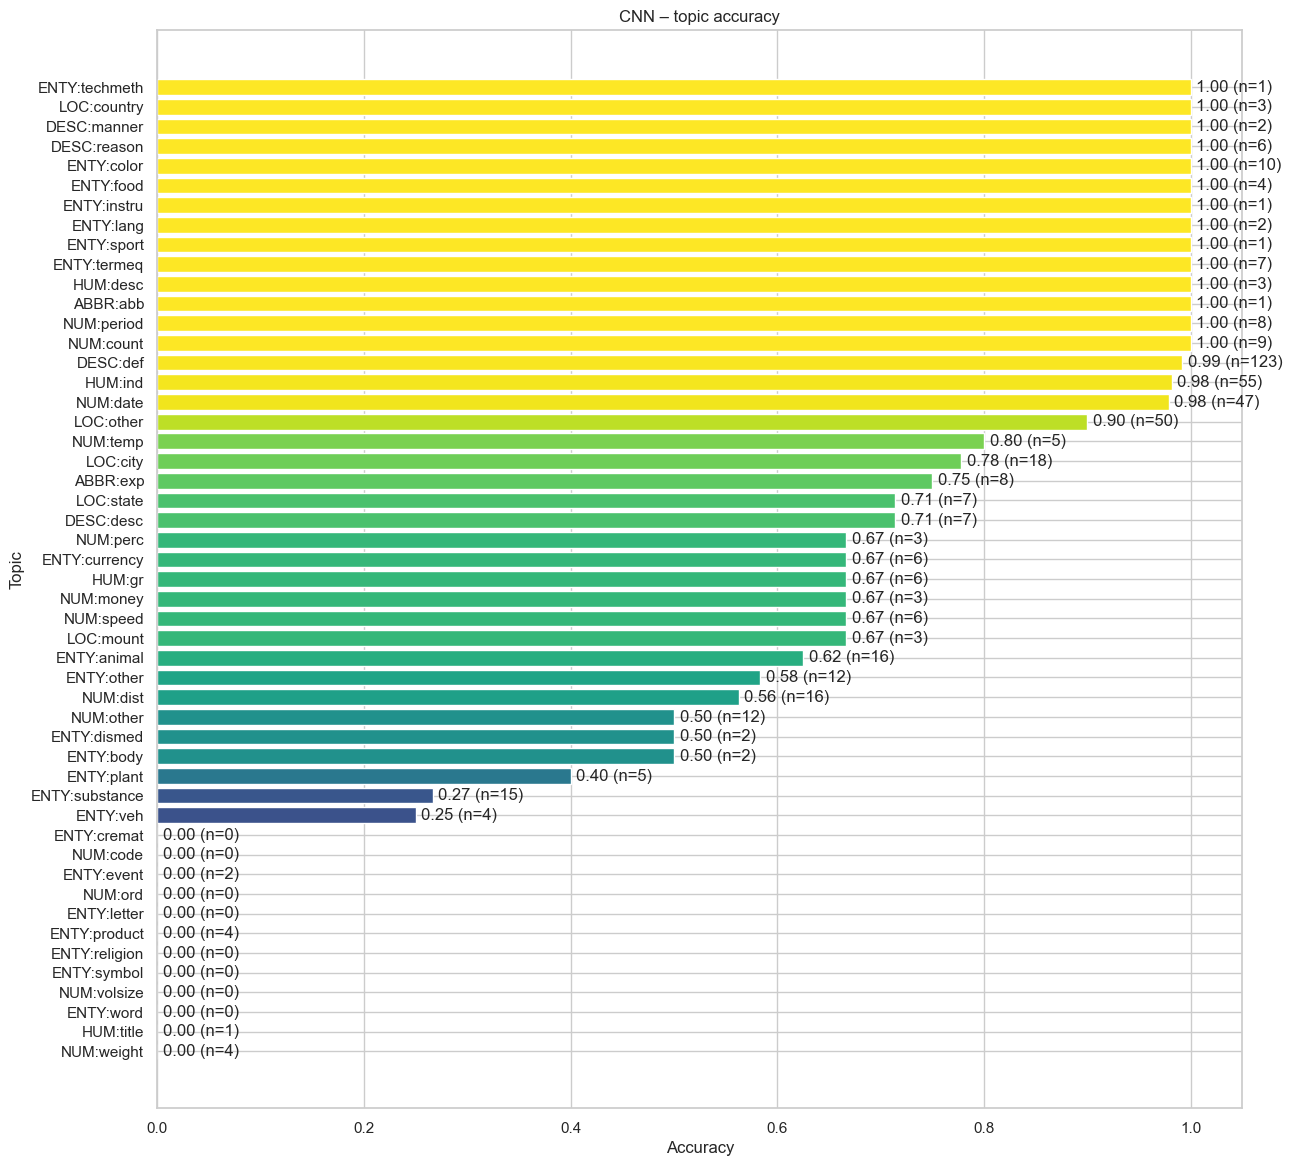

In [22]:
comparison_df = pd.DataFrame(records['rows']).set_index('name').sort_values('test_accuracy', ascending=False)
display(comparison_df)

best_name = comparison_df.index[0]
best_eval = records['evaluations'][best_name]
best_history = records['histories'][best_name]
best_label_map = records['label_maps'][best_name]
display(Markdown(f"Best model: **{best_name}** (test accuracy {comparison_df.loc[best_name, 'test_accuracy']:.3f})"))
fig, ax = plt.subplots(figsize=(14, 5))
best_topic_df = topic_accuracy_table(best_eval, best_label_map)
sorted_best_topics = best_topic_df.sort_values('accuracy')
display(sorted_best_topics)
fig, ax = plt.subplots(figsize=(14, 14))
color_vals = [cm.get_cmap('viridis')(acc) for acc in sorted_best_topics['accuracy'].clip(0, 1)]
bars = ax.barh(sorted_best_topics['label'], sorted_best_topics['accuracy'], color=color_vals)
ax.set_xlabel('Accuracy')
ax.set_ylabel('Topic')
ax.set_title(f"{best_name.upper()} – topic accuracy")
ax.set_xlim(0, 1.05)
ax.bar_label(bars, labels=[f"{acc:.2f} (n={supp})" for acc, supp in zip(sorted_best_topics['accuracy'], sorted_best_topics['support'])], padding=4)
norm = colors.Normalize(0, 1)
sm = cm.ScalarMappable(cmap=cm.get_cmap('viridis'), norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Accuracy scale')
plt.tight_layout()
fig.savefig(f"plots/part3_{best_name}_topic_accuracy.png", dpi=300)
plt.show()

best_report_df = classification_report_table(best_eval, best_label_map)
label_rows = best_report_df.loc[~best_report_df.index.isin(['accuracy', 'macro avg', 'weighted avg', 'micro avg'])].copy()
if 'accuracy' not in label_rows.columns:
    label_rows['accuracy'] = label_rows.get('recall', 0.0)

fig, ax = plt.subplots(figsize=(14, 5))
support_colors = [cm.get_cmap('magma')(acc) for acc in label_rows['accuracy'].clip(0, 1)]
bars = ax.bar(label_rows.index, label_rows['support'], color=support_colors)
ax.set_xlabel('Topic')
ax.set_ylabel('Support')
ax.set_title(f"{best_name.upper()} – support by topic (color = accuracy)")
ax.set_ylim(0, label_rows['support'].max() * 1.1)
for bar, accuracy in zip(bars, label_rows['accuracy']):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f"{accuracy:.2f}", ha='center', va='bottom', fontsize=9)
sm = cm.ScalarMappable(cmap=cm.get_cmap('magma'), norm=colors.Normalize(0, 1))
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
fig.savefig(f"plots/part3_{best_name}_classification_support.png", dpi=300)
plt.show()

fig, ax = plt.subplots(figsize=(14, 5))
f1_colors = [cm.get_cmap('plasma')(score) for score in label_rows['f1-score'].clip(0, 1)]
bars = ax.bar(label_rows.index, label_rows['f1-score'], color=f1_colors)
ax.set_xlabel('Topic')
ax.set_ylabel('F1 score')
ax.set_title(f"{best_name.upper()} – F1 score by topic")
ax.set_ylim(0, 1.05)
for bar, score in zip(bars, label_rows['f1-score']):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f"{score:.2f}", ha='center', va='bottom', fontsize=9)
plt.xticks(rotation=45)
plt.tight_layout()
fig.savefig(f"plots/part3_{best_name}_classification_f1.png", dpi=300)
plt.show()

averages_df = best_report_df.loc[
    ['accuracy', 'macro avg', 'weighted avg'],
    [col for col in best_report_df.columns if col in ['precision', 'recall', 'f1-score', 'support']],
]
display(averages_df)
